In [17]:
# import libraries which can read h5 files
import h5py
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm

from scipy import signal
import os

# change to inline plotting
%matplotlib inline

In [18]:
def moving_average_fast(x, w):
    x = np.mean(x.reshape(x.shape[0], -1, w), -1)
    return x

def taper(data, fs, half_length):  # half_length is in seconds
    Hann = signal.hann(int(half_length * fs * 2.0) + 1)
    length = int(Hann.shape[0] / 2.0)
    data_taper = data
    taper_function = np.ones(data.shape[1])
    taper_function[0:length] = Hann[0:length]
    taper_function[data.shape[1] - length:data.shape[1]] = Hann[Hann.shape[0] - length:Hann.shape[0]]

    for i in range(data.shape[0]):
        data_taper[i, :] = np.multiply(data[i, :], taper_function)
    return data_taper

def filter(data, f, fmin, fmax):
    sos = signal.iirfilter(4, [fmin, fmax], fs=f, btype='band', analog=False, ftype='butter', output='sos')
    data_filter = signal.sosfiltfilt(sos, data)
    return data_filter

In [19]:
def clean_file(data): # sensors x time
    delta = 0.01  # [s] data sampling interval5
    time = np.arange(0, data.shape[1] * delta, delta)  # time series for the data

    ### Preprocessing the data;
    ## Fmin and Fmax can be changed;
    ## filter range can be 0.1-50 Hz; Here 1-10 Hz is just an example
    F = 1 / delta  # [Hz] data sampling rate
    Fmin = 1  # [Hz] bandpass min freq
    Fmax = 10  # [Hz] bandpass max freq
    Taper_window = 2.0 # 2 seconds Hanning taper window

    data = np.gradient(data, axis=1) / delta  # differentiate data converting strain waveforms to strain rate
    data = signal.detrend(data, type='linear')  # remove linear trend
    data = signal.detrend(data, type='constant')  # remove mean
    data = taper(data, F, Taper_window)  # taper the waveforms with a Hanning filter [optional; taper is for the next bandpass]
    data = filter(data, F, Fmin, Fmax)  # bandpass filter the data [optional]

    return data

In [20]:
def read_file(file_name, resample_rate=10, split_rate=40):
    f = h5py.File(f'/Tmp/dingqian/Ocean/{file_name}', 'r')
    data = f['Data'][:]
    print(data.shape)
    data = data[::resample_rate,:]
    data = clean_file(data)
    print(data.shape)

    # data_resample = data[::resample_rate,:].T # resample per 10 stations
    data = data.T

    # Only filter for building the dataset.

    # data -= np.median(data, axis=1, keepdims=True)
    # data -= np.mean(data, axis=0)
    # data /= np.std(data, axis=0)
    
    data_splits = np.split(data, split_rate, axis=0) # to 90 seconds splits

    return data_splits

def read_catalog(file_name):
    # read file using open
    with open(f'data/{file_name}', 'r') as f:
        catalog = f.readlines()
    return catalog

In [21]:
def file_to_npz(data_splits, file_name, set_name, starting_time, interval, catalog, save=False):
    npz_list = []
    has_list = []
    
    for i, data in enumerate(tqdm(data_splits)):
        meta = {}
        meta['data'] = data.astype(np.float64) # (9000, 3260)
        meta['time_start'] = starting_time

        ending_time = starting_time + timedelta(seconds=interval*data.shape[0])

        # save meta to npz
        file_prefix = file_name.split('.')[0]

        if save:
            save_path = f'/Tmp/dingqian/Ocean/splits/{set_name}/{file_prefix}-{i}.npz'
            print(save_path)
            # check if save_path does not exists, then create the path with makedirs
            if not os.path.exists(os.path.dirname(save_path)):
                os.makedirs(os.path.dirname(save_path))

            np.savez_compressed(save_path, **meta)
        
        # check if there is any time in catalog between starting_time and ending_time
        for cat_time in catalog:
            # print(cat_time, starting_time, ending_time)
            if starting_time <= cat_time <= ending_time:
                # meta['catalog'] is the number of seconds between starting_time and cat_time divided by interval
                meta['catalog'] = (cat_time - starting_time).seconds / interval
                has_list.append(i)

        npz_list.append(meta)
        starting_time = ending_time
    
    return npz_list, has_list

In [22]:
def plot_data(data):
    data -= np.median(data, axis=1, keepdims=True)
    data -= np.mean(data, axis=0)
    data /= np.std(data, axis=0)

    # data = data[:, 200:400]

    plt.figure(figsize=(10, 8))
    plt.imshow(data.T, vmin=-2.0, vmax=2.0, cmap="seismic", aspect='auto')
    plt.gca().invert_yaxis()
    plt.xlabel("Time")
    plt.ylabel("Station")

In [23]:
def extract_starting_time_str(file_name):
    file_prefix = file_name.split('.')[0]
    time_str = file_prefix.split('-')[-3:]
    time_str = '-'.join(time_str)[:-1]
    time_ret = datetime.strptime(time_str, '%Y-%m-%dT%H%M%S')
    return time_ret

In [24]:
catalog = read_catalog('catalog.DAS')
#strptime where seconds in decimal

catalog = [datetime.strptime(line.split()[0], '%Y-%m-%dT%H:%M:%S.%f') for line in catalog]
catalog[0]

datetime.datetime(2021, 11, 1, 22, 1, 16, 68000)

In [25]:
file_name = 'Cascadia-North-2021-11-01T215345Z.h5' # 100 Hz
set_name = 'train_npz'
data_splits = read_file(file_name) # segment in 90 seconds, size in (9000, 3260)
starting_time = extract_starting_time_str(file_name)
interval = 0.01

npz_list = file_to_npz(data_splits, file_name, set_name, starting_time, interval, catalog, save=False)

(32600, 360000)
(3260, 360000)


100%|██████████| 40/40 [00:01<00:00, 30.02it/s]


In [26]:
file_name = 'Cascadia-North-2021-11-01T225345Z.h5' # 100 Hz
set_name = 'test_npz'
data_splits = read_file(file_name) # segment in 90 seconds, size in (9000, 3260)
starting_time = extract_starting_time_str(file_name)
interval = 0.01

npz_list, has_list = file_to_npz(data_splits, file_name, set_name, starting_time, interval, catalog, save=False)

(32600, 360000)
(3260, 360000)


100%|██████████| 40/40 [00:01<00:00, 29.84it/s]


In [27]:
npz_list[1]

{'data': array([[-5.01949500e+03, -2.24789364e+04, -3.35085814e+02, ...,
          4.13105307e+04,  1.51171528e+06, -1.23651436e+06],
        [-2.10201604e+04, -1.94415029e+04, -4.29920987e+02, ...,
          6.32300889e+05, -3.26237599e+04,  1.94502661e+06],
        [-2.30050363e+04, -2.93593488e+03, -1.74230320e+02, ...,
          8.84980740e+05, -1.13493513e+06,  4.46252436e+06],
        ...,
        [-2.31368199e+04, -9.94392122e+03,  2.33809125e+02, ...,
         -3.68685213e+06,  2.58770327e+06,  6.62107192e+05],
        [ 9.30431956e+02, -1.20943409e+03,  2.53843560e+03, ...,
         -5.43952037e+06,  2.03838890e+06,  1.29079989e+06],
        [ 2.35398798e+04,  7.03245172e+03,  3.42387461e+03, ...,
         -4.90376375e+06,  4.46920440e+05,  9.58167423e+05]]),
 'time_start': datetime.datetime(2021, 11, 1, 22, 55, 15)}

In [28]:
npz_list[3]

{'data': array([[-6.89363394e+04, -1.86973751e+04,  1.63116580e+03, ...,
          3.92748706e+06, -2.02502840e+06,  1.68568153e+06],
        [-7.41573108e+04, -1.83707631e+04,  1.90347169e+03, ...,
          3.23963526e+06, -1.42693489e+06,  2.16109076e+06],
        [-4.47575160e+04, -9.91433871e+03,  2.17304447e+03, ...,
          6.34618617e+05, -4.76109142e+05,  2.00358459e+06],
        ...,
        [-4.55212597e+04, -3.51907587e+02,  5.69993969e+03, ...,
          2.97544352e+06,  1.72780262e+06,  1.33931494e+06],
        [-3.70109228e+04, -5.24631517e+02,  1.06197233e+04, ...,
          5.22321512e+06,  6.20195377e+04,  1.61582365e+06],
        [-1.16348619e+04,  1.25610622e+03,  1.01328875e+04, ...,
          5.92469089e+06, -1.82976415e+06,  1.26266152e+06]]),
 'time_start': datetime.datetime(2021, 11, 1, 22, 58, 15),
 'catalog': 4000.0}

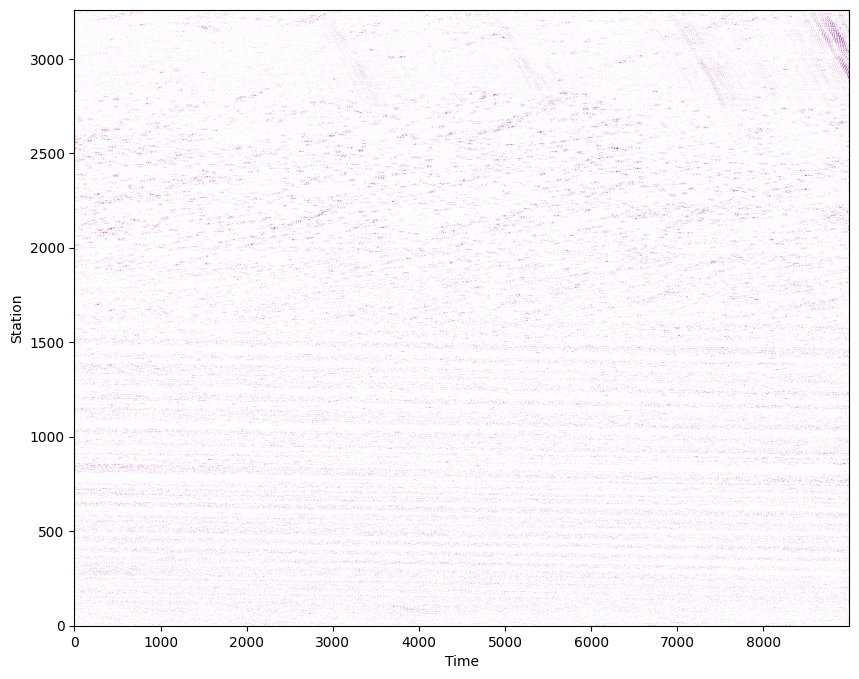

In [15]:
plot_data(npz_list[3]['data'])

In [11]:
print(npz_list[0]['catalog'])

100.0


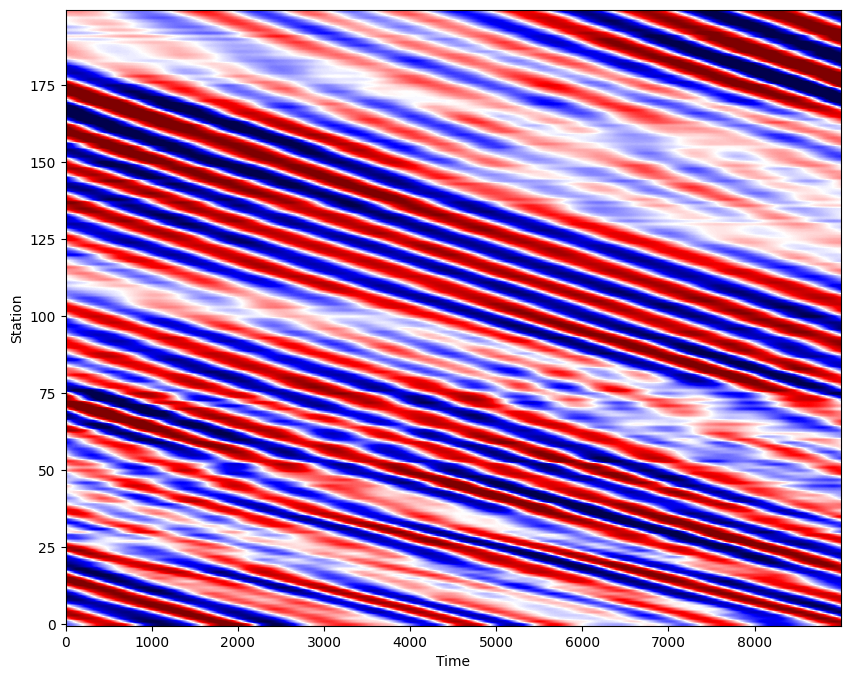

In [16]:
plot_data(data_splits[12])

In [33]:
############# For paper


def load_file(f):
    print(f)
    meta = np.load(f)
    data = meta["data"][2000: 5600]
    data = data[:, -500:]
    print(data.shape)
    print(meta.files)
    
    data -= np.median(data, axis=1, keepdims=True)
    data -= np.mean(data, axis=0)
    data /= np.std(data, axis=0)
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.pcolormesh(data.T, vmin=-2.0, vmax=2.0, cmap="seismic")
    plt.gca().invert_yaxis()
    # plt.xlabel("Station")
    # plt.ylabel("Time")


/u/dingqian/some/MAT/data/DAS/test_npz/2019-08-25T10-36-27-M3-19km.npz
(3600, 500)
['data', 'p_picks', 's_picks', 'p_pred', 's_pred', 'p_score', 's_score']


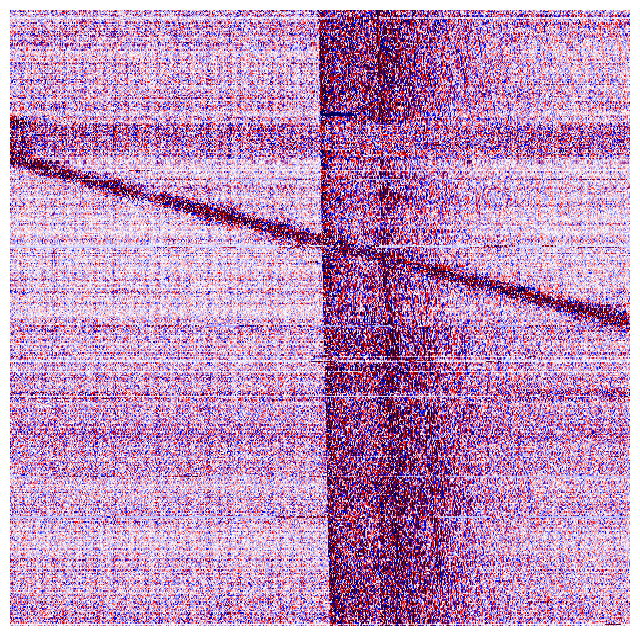

In [34]:
file_path = '/u/dingqian/some/MAT/data/DAS/test_npz/2019-08-25T10-36-27-M3-19km.npz'
load_file(file_path)